# Predição de exportação de grãos no porto de Santarém com Inteligencia Artificial.

O porto grãos de Santarém, atualmente administrado pela empresa Cargill, se encontra na rota de exportação de grãos brasileiros, sendo responsável pela exportação dos grãos provenientes, principalmente, do norte do mato grosso, roraima e oeste do pará, recebendo os mesmos por via fluvial atráves dos portos de Porto Velho e Miritituba e também rodoviário diretamente no porto.

Essa análise tem o objetivo de estudar o cenário de exportação dos grãos, no caso milho e soja, e criar um modelo de inteligencia artificial capaz de predizer como será o ano de 2020.

Para esse modelo não foram realizados ajustes levando em consideração o cenário de Covid-19, visto que o setor de linha de produção de alimentos não foi tão afetado.

Sumário


1.   [Importação e Limpeza de Dados](#import)
2.   [Analises Gráficas](#analisesgraficas)
3.   [Regressão pelo Método de Fourier](#regressao)
4.   [Modelo Final](#modelofinal)
5.   [Considerações Finais](#conclusao)





In [1]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sns.set_style('whitegrid')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
from math import sqrt

## Importação e Limpeza de Dados <a name="import"></a>


Primeiramente vamos importar a tabela de exportações completa do site do ministério do comercio exterior. Essa tabela é atualizada mensalmente com os dados do mês anterior.

A tabela terá cada linha como uma exportação ocorrida é como a seguir:


In [3]:
url = 'http://www.mdic.gov.br/balanca/bd/comexstat-bd/ncm/EXP_COMPLETA.zip'
df = pd.read_csv(url,sep=';')
df.head()

,CO_ANO,CO_MES,CO_NCM,CO_UNID,CO_PAIS,SG_UF_NCM,CO_VIA,CO_URF,QT_ESTAT,KG_LIQUIDO,VL_FOB
0,1997,3,41043911,15,149,RS,1,1010500,3987,4150,16725
1,1997,5,63019000,10,97,MG,7,145200,0,1002,8420
2,1997,6,87168000,11,586,RS,7,145300,48,153,915
3,1997,8,39162000,10,249,SP,1,817800,0,138,586
4,1997,2,73130000,10,63,SP,7,1010900,0,2714,1972


A documentação completa pode ser verificada no site http://www.mdic.gov.br/index.php/comercio-exterior/estatisticas-de-comercio-exterior/base-de-dados-do-comercio-exterior-brasileiro-arquivos-para-download

As principais features que vamos utilizar aqui são as seguintes:

**CO_ANO** e **CO_MES** que representam o ano e mês do lançamento.

**CO_NCM** representa o NCM do produto, que iremos filtrar futuramente para o milho e soja, que são nossos produtos de interesse.

**KG_LIQUIDO** o KG efetivamente exportado

**CO_URF** significa o porto de onde se originou a exportação, será filtrado para santarém.

**CO_PAIS** é o país para onde foi exportado. Mantive essas linhas para possiveis análises posteriores, entretano não foram explorados nesse notebook.


Iniciaremos com o filtro do porto.

In [0]:
Porto = 210200
df_sant = df[df['CO_URF']==Porto] #Codigo de BRSTM retirado do arquivo TABELAS_AUXILIARES Sheet 16

Em seguida do NCM, ajustando as colunas para nomes mais legíveis.

In [0]:
NCM = pd.read_csv('http://www.mdic.gov.br/balanca/bd/tabelas/NCM.csv',sep=';',encoding='latin-1') #import dicionário de NCM e dá merge
NCM_clean = NCM[['CO_NCM','NO_NCM_POR']].copy()
sant = df_sant.merge(NCM_clean,left_on='CO_NCM',right_on='CO_NCM')
sant.columns = ['Ano','Mes','NCM','UNID','Pais','UF','Via','URF','Qnt_Estat','KG','VL_FOB','Desc']

Faremos também a tradução do ID do país para o nome do mesmo.

In [0]:
sant['NCM'] = sant['NCM'].apply(lambda x: str(x).zfill(8)[:4]) #Normaliza NCM pra 8 digitos e pega os 4 primeiros, conhecido como SH4
sant_grao = sant[sant['NCM'].isin(['1201','1005'])] #soja e milho, respectivamente

pais = pd.read_csv('http://www.mdic.gov.br/balanca/bd/tabelas/PAIS.csv',sep=';',encoding='latin-1') #importa dicionário de países
pais = pais[['CO_PAIS','NO_PAIS']]

sant_grao=sant_grao.merge(pais,left_on='Pais',right_on='CO_PAIS')
sant_grao.drop(axis=1,labels=['Pais','CO_PAIS','URF','UNID'],inplace=True)

mes_atual = sant_grao[sant_grao['Ano']==2020]['Mes'].max() + 1 #Ajuste para o mês que estamos.

Criaremos uma coluna data que basicamente irá unir as informações de ano e mes.

In [0]:
sant_grao['Data'] = sant_grao.apply(lambda x: pd.to_datetime(str(x['Mes']) +'/'+ str(x['Ano'])),axis=1)
#coluna data usando o formato datetime
sant_grao.to_csv('graos_santarem.csv')

##Análises Gráficas <a name="*analisesgraficas*"></a>


A seguir gráficos demonstrando as exportações totais de grãos.

O quarto gráfico demonstra as exportações de 2020 e para os meses que ainda não existem dados em 2020, 2019.


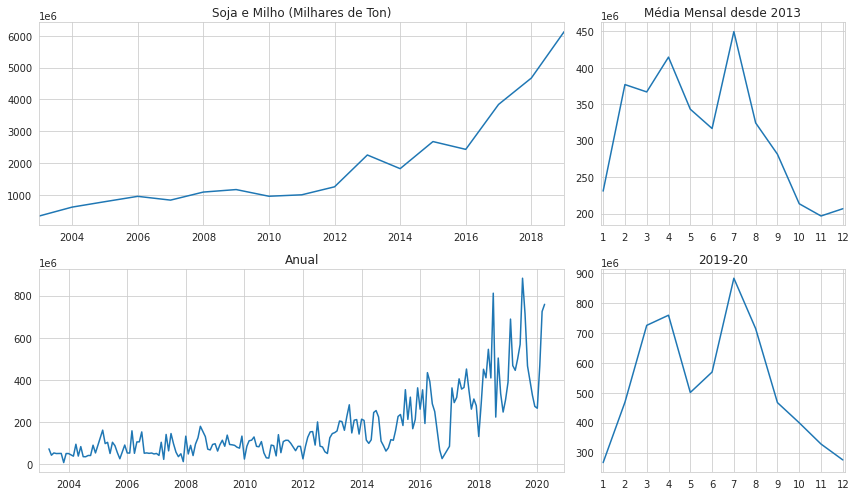

In [8]:
plt.figure(figsize=(12,7))

ax1 = plt.subplot2grid((2, 3), (0, 0),colspan=2)
ax1.set_title('Soja e Milho (Milhares de Ton)')
ax1.ticklabel_format(axis='y',scilimits=(6,6))
ax1.set_xlim([2003,2019])

ax2 = plt.subplot2grid((2, 3), (0, 2))
ax2.set_title('Média Mensal desde 2013')
ax2.ticklabel_format(axis='y',scilimits=(6,6))
plt.xticks(np.arange(1,13))
ax2.set_xlim([0.9,12.1])

ax3 = plt.subplot2grid((2, 3), (1, 0),  colspan=2)
ax3.ticklabel_format(axis='y',scilimits=(6,6))
ax3.set_title('Anual')
ax3.set_xlim([datetime.date(2003,1,1),datetime.date(2020,12,1)])

ax4 = plt.subplot2grid((2, 3), (1, 2))
ax4.set_title('2019-20')
ax4.ticklabel_format(axis='y',scilimits=(6,6))
plt.xticks(np.arange(1,13))
ax4.set_xlim([0.9,12.1])



sns.lineplot(data=sant_grao.groupby('Ano').sum()['KG'],ax=ax1)
sns.lineplot(data=sant_grao[(sant_grao['Ano']>=2013)].groupby('Mes').sum()['KG']/7,ax=ax2)
sns.lineplot(data=sant_grao.groupby('Data').sum()['KG'],ax=ax3)
sns.lineplot(data=sant_grao[sant_grao['Data']>f"2019-{mes_atual-1:02d}-01"].groupby('Mes').sum()['KG'],ax=ax4)


plt.tight_layout()
#Soja e Milho somados

Os mesmos gráficos dessa vez separando soja e milho.


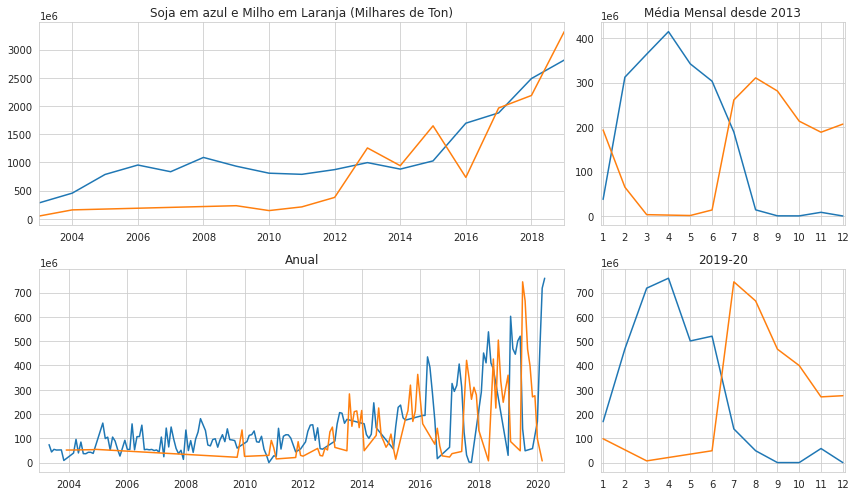

In [9]:
Soja = str(1201)
Milho = str(1005)

plt.figure(figsize=(12,7))

ax1 = plt.subplot2grid((2, 3), (0, 0),colspan=2)
ax1.set_title('Soja em azul e Milho em Laranja (Milhares de Ton)')
ax1.ticklabel_format(axis='y',scilimits=(6,6))
ax1.set_xlim([2003,2019])

ax2 = plt.subplot2grid((2, 3), (0, 2))
ax2.set_title('Média Mensal desde 2013')
ax2.ticklabel_format(axis='y',scilimits=(6,6))
plt.xticks(np.arange(1,13))
ax2.set_xlim([0.9,12.1])

ax3 = plt.subplot2grid((2, 3), (1, 0),  colspan=2)
ax3.ticklabel_format(axis='y',scilimits=(6,6))
ax3.set_title('Anual')
ax3.set_xlim([datetime.date(2003,1,1),datetime.date(2020,12,1)])

ax4 = plt.subplot2grid((2, 3), (1, 2))
ax4.set_title('2019-20')
ax4.ticklabel_format(axis='y',scilimits=(6,6))
plt.xticks(np.arange(1,13))
ax4.set_xlim([0.9,12.1])





sns.lineplot(data=sant_grao[sant_grao['NCM']==Soja].groupby('Ano').sum()['KG'],ax=ax1)
sns.lineplot(data=(sant_grao[(sant_grao['NCM']==Soja)&(sant_grao['Ano']>=2013)].groupby('Mes').sum()['KG']/7).reindex(range(1,13),fill_value=0),ax=ax2)
sns.lineplot(data=sant_grao[sant_grao['NCM']==Soja].groupby('Data').sum()['KG'],ax=ax3)
sns.lineplot(data=sant_grao[(sant_grao['NCM']==Soja)&(sant_grao['Data']>f"2019-{mes_atual-1:02d}-01")].groupby('Mes').sum()['KG'].reindex(range(1,13),fill_value=0),ax=ax4)


sns.lineplot(data=sant_grao[sant_grao['NCM']==Milho].groupby('Ano').sum()['KG'],ax=ax1)
sns.lineplot(data=sant_grao[(sant_grao['NCM']==Milho)&(sant_grao['Ano']>=2013)].groupby('Mes').sum()['KG']/7,ax=ax2)
sns.lineplot(data=sant_grao[sant_grao['NCM']==Milho].groupby('Data').sum()['KG'],ax=ax3)
sns.lineplot(data=sant_grao[(sant_grao['NCM']==Milho)&(sant_grao['Data']>f"2019-{mes_atual-1:02d}-01")].groupby('Mes').sum()['KG'],ax=ax4)
# após o mês 04 é 2019, antes é 2020


plt.tight_layout()
#Soja e Milho Separados

É possivel notar que o ano de 2016/17 para o milho houve uma descontinuidade, é possível perceber no terceiro gráfico que existe uma queda no mesmo que só será recuperada em 2017/18.

Entraremos mais a fundo futuramente desse ponto.

Outro ponto importante é que é possivel notar que existe uma tendencia de crescimento nas exportações. Para confirmar, foi feito um grafico com a soma das exportações por ano e uma reta tentando aproximar esse crescimento de um crescimento linear.

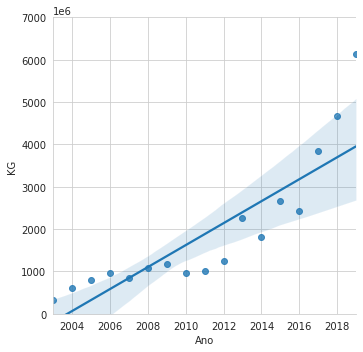

In [10]:
sns.lmplot(data=sant_grao[(sant_grao['Ano']<=2019)].groupby('Ano').sum().reset_index(),y='KG',x='Ano',robust=True)
plt.ticklabel_format(axis='y',scilimits=(6,6))
plt.ylim([0,7000000000])
plt.show()

Como é possivel perceber, não só há uma tendencia de crescimento, como ela não é lienar, mas possivelmente quadrática, é possivel perceber essa tendencia a partir de 2009.

##Regressão por Método de Fourier <a name="regessao"></a>

Para realizar a regressão, utilizaremos um modelo com basicamente duas parcelas:

###Série de Fourier

A série de Fourier consiste na soma de senos e cossenos para aproximar funções descontínuas ou sazonais, que é o nosso caso.
Ela considera a soma de ondas que estão em fases diferentes e diferentes amplitudes para formar uma onda complexa.

Mais informações podem ser encontradas em: https://pt.wikipedia.org/wiki/S%C3%A9rie_de_Fourier

Para esse problema, utilizei 5 séries de senos e cossenos, visto que acima disso os resultados não variavam, apenas aumentando o tempo computacional.

$ Fourier = \sum_{i=1}^{5} (A_i)*(-cos((N_i*\frac{x}{12})*\pi*2)+1) + (B_i)(-sin((N_i*\frac{x}{12})*\pi*2)+1) $
 
$A_i$ e $B_i$ se referem a aplitude das ondas, $N_i$ é a fase, o termo $\frac{x}{12}$ explicita a sazonalidade para 12 periodos, $pi*2$ corrige o valor para radianos e o $+1$ serve para garantir que o valor não seja nulo, o que geraria um problema ao multiplicar pela função quadrática.

###Função quadrática

Para a função quadrática foi utilizada a seguinte equação: 

$\ Fun$ $Quadratica =  ( -Fx + \frac{x}{E})^2 *D + C $

Os valores de f e d servem para ajustar em que momento inicia o ajuste quadrático, o quão rapido ele cresce e qual sua amplitude.


É possivel de se argumentar que os valores de F, D e E poderiam ser resumidos a uma unica constante, entretanto, ao testar no método, o tempo computacional foi reduzido com estes separados.

### Modelo

O modelo implementado final é dado por $ Fun$ $Quadratica * Fourier + C$

Onde se C trata de um ajuste para inicio fora de zero, uma constante independente.

Além disso foi implementado um ajuste para caso o resultado seja abaixo de 0, o mesmo retorne 1.
O valor 1 foi escolhido para evitar problemas de divisão por 0 nos calculos de erro, ainda sendo pequeno o bastante pelos resultados estarem na ordem de centenas de milhares.


In [0]:
#Implementação da função
def func(x,n1,n2,n3,n4,n5,a1,a2,a3,a4,a5,b1,b2,b3,b4,b5,c,d,e,f):
  retorno = ((a1)*(-np.cos((n1*x/12)*np.pi*2)+1) + (b1)*(-np.sin((n1*x/12)*np.pi*2)+1) + \
             (a2)*(-np.cos((n2*x/12)*np.pi*2)+1) + (b2)*(-np.sin((n2*x/12)*np.pi*2)+1) + \
             (a3)*(-np.cos((n3*x/12)*np.pi*2)+1) + (b3)*(-np.sin((n3*x/12)*np.pi*2)+1) + \
             (a4)*(-np.cos((n4*x/12)*np.pi*2)+1) + (b4)*(-np.sin((n4*x/12)*np.pi*2)+1) + \
             (a5)*(-np.cos((n5*x/12)*np.pi*2)+1) + (b5)*(-np.sin((n5*x/12)*np.pi*2)+1) )*\
            (( (-f*x) + x/e)**2) *d + c
  retorno = pd.Series(retorno).map(lambda x: 1 if (x < 0) else x)
  return retorno

Como citado anteriormente houve uma descontinuidade na exportação de milho, assim iremos criar modelos diferentes, tratando das particularidades de cada grão em seu modelo, para somar os dois ao final.

###Soja

Iniciando pela soja, foi criado uma coluna mesNorm para contar os meses a partir de 2009, onde foi identificado o inicio da tendencia. Além disso os valores foram divididos em treino para antes de 2020 e teste para após 2020


In [0]:
ano_pesquisa = 2009
dfSoja = sant_grao[(sant_grao['NCM']==Soja)].copy()
dfSoja['mesNorm'] = (dfSoja['Ano']-ano_pesquisa)*12 + dfSoja['Mes'] 
coef = 2020 - ano_pesquisa #meses a partir do ano de pesquisa que resultam em 2020
new_index = range(0*12,12*coef)
predSoja_train = dfSoja[(dfSoja['mesNorm']>=0)].groupby(['mesNorm']).sum()['KG'].reindex(new_index, fill_value=0)
new_index = range(12*coef+1,12*coef+5)
predSoja_test = dfSoja[(dfSoja['mesNorm']>=0)].groupby(['mesNorm']).sum()['KG'].reindex(new_index, fill_value=0)
   

Realizado o fit da curva considerando tendo como resultado a curva modelo com erro médio quadratico apresentado a seguir.


RMSE: 51.668589164495124 mil ton


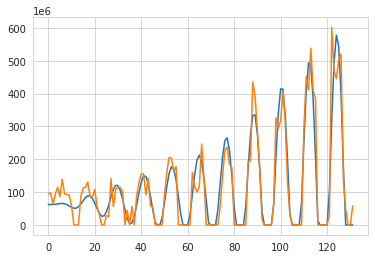

In [13]:
popts, pcov = curve_fit(func, predSoja_train.index, predSoja_train.values,maxfev=12000,absolute_sigma=True)

plt.plot(predSoja_train.index, func(predSoja_train.index, *popts))
plt.plot(predSoja_train)
plt.ticklabel_format(axis='y',scilimits=(6,6))

RMSE = sqrt(mean_squared_error(predSoja_train, func(predSoja_train.index, *popts)))
print(f'RMSE: {RMSE/1000000} mil ton')

Por fim, verificado o erro dos modelos com o resultado apresentado a seguir.


RMSE: 46 mil ton
Erro máximo: 68 mil ton


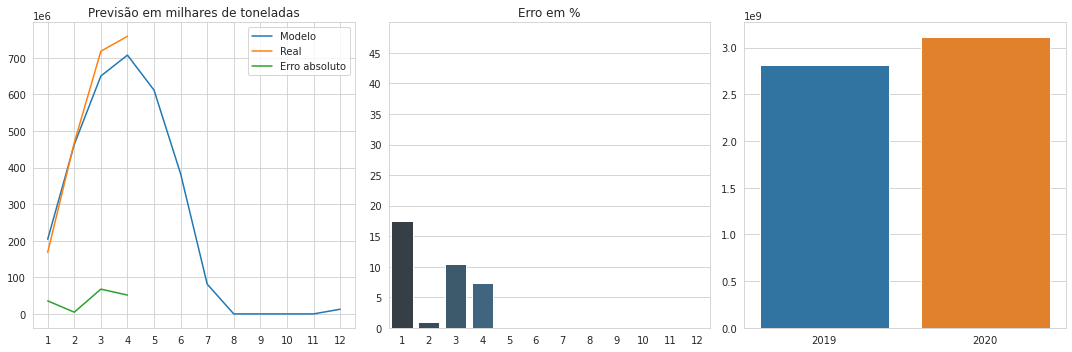

A exportação de soja esperada para 2020 será de 3,114 milhares de ton, 301 mil ton acima de 2019.


In [14]:
erro = pd.Series(data=(func(range(12*coef+1,12*coef+13), *popts) - predSoja_test.reset_index(drop=True).fillna(0)).apply(lambda x: sqrt(x**2)))
erro_prop = ((erro/func(range(12*coef+1,12*coef+13), *popts))*100)
erro_prop.index = erro_prop.index+1
plt.figure(figsize=(15,5))


ax1 = plt.subplot(131)
plt.plot(range(12*coef+1,12*coef+13), func(range(12*coef+1,12*coef+13), *popts), label='Modelo')
plt.plot(predSoja_test, label='Real')
plt.plot(range(12*coef+1,12*coef+13),erro,label='Erro absoluto')
RMSE = sqrt(mean_squared_error(predSoja_test, func(predSoja_test.index, *popts)))
plt.legend()
plt.ticklabel_format(axis='y',scilimits=(6,6))
plt.title('Previsão em milhares de toneladas')
plt.xticks(range(12*coef+1,12*coef+13),range(1,13))
print(f'RMSE: {format(RMSE/1000000,".0f")} mil ton')
print(f'Erro máximo: {format(erro.max()/1000000,".0f")} mil ton')

ax2 = plt.subplot(132)
sns.barplot(x=erro_prop.index,y=erro_prop,ax=ax2,palette='Blues_d')
plt.ylim([0,50])
plt.yticks(np.arange(0,50,step=5))
plt.title('Erro em %')


ax3 = plt.subplot(133)
exp_2020 = sum(func(range(12*coef+1,12*coef+13), *popts))
exp_2019 = sum(sant_grao[(sant_grao['NCM']==Soja)&(sant_grao['Ano']==2019)].groupby('Data').sum()['KG'])

sns.barplot(x=[2019,2020],y=[exp_2019,exp_2020],ax=ax3)

plt.tight_layout()
plt.show()

print(f'A exportação de soja esperada para 2020 será de {exp_2020/1000000:,.0f} milhares de ton, {(exp_2020-exp_2019)/1000000:,.0f} mil ton acima de 2019.')



O modelo retornou erros abaixo de 100 mil ton, representando menos de 20% para valores no inicio de safra e menos de 10% para valores no topo da safra!
Além disso aqui já temos uma previsão do total que será exportado em 2020 em comparação com 2019.

###Milho


Os mesmos passos iniciais foram aplicados ao milho, mas para esse caso é preciso tratar a safra 16/17.

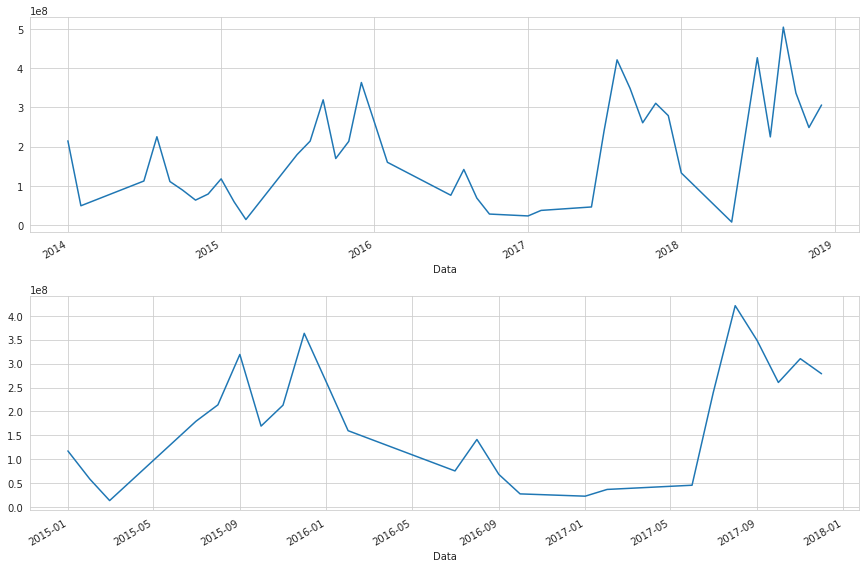

In [15]:
dfMilho = sant_grao[(sant_grao['NCM']==Milho)].copy()
plt.figure(figsize = (12,8))
ax1 = plt.subplot(211)
dfMilho[(dfMilho['Ano'] >= 2014)&(dfMilho['Ano'] <= 2018)].groupby('Data').sum()['KG'].plot()
ax2 = plt.subplot(212)
dfMilho[(dfMilho['Ano'] >= 2015)&(dfMilho['Ano'] <= 2017)].groupby('Data').sum()['KG'].plot()
plt.tight_layout()

Uma rápida pesquisa no google e foi descoberto que o que ocorreu foi uma união entre a safra tardia de soja, o que atrasou o plantil de milho, e um clima desfavorável, causando uma "safra perdida".

https://www.canalrural.com.br/programas/milho-2016-entra-para-calendario-como-ano-crise-65453/

A correção será feita entre o mês 05 de 2016 e 05 de 2017, considerando para o mês a média entre os anos anterior e posterior nesse mês.


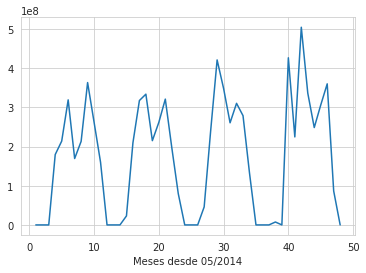

In [16]:
ano_pesquisa = 2009
dfMilho['mesNorm'] = (dfMilho['Ano']-ano_pesquisa)*12 + dfMilho['Mes'] 
coef = 2020 - ano_pesquisa #meses a partir do ano de pesquisa que resultam em 2020
coef_2016 = 2016 - ano_pesquisa #meses a partir do ano de pesquisa que resultam em 2016
new_index = range(0*12,12*coef)
predMilho_train = dfMilho[(dfMilho['mesNorm']>=0)].groupby(['mesNorm']).sum()['KG'].reindex(new_index, fill_value=0)
new_index = range(12*coef+1,12*coef+5)
predMilho_test = dfMilho[(dfMilho['mesNorm']>=0)].groupby(['mesNorm']).sum()['KG'].reindex(new_index, fill_value=0)
 
for n in range(coef_2016*12+5,coef_2016*12+5+12): #ajuste de 2016
  predMilho_train[n] = (predMilho_train[n-12] + predMilho_train[n+12])/2

plt.plot(range(1,49) ,predMilho_train[n-24:n+24])
plt.xlabel('Meses desde 05/2014')
plt.show()

O resultado ajustado parece ok, seguiremos o treinamento.

RMSE: 73.58977112864135 mil ton


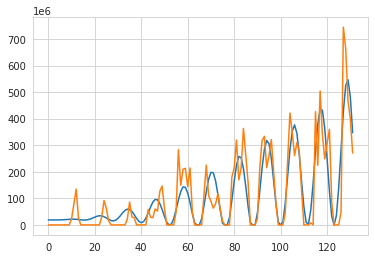

In [17]:
poptm, pcov = curve_fit(func, predMilho_train.index, predMilho_train.values,maxfev=12000)

plt.plot(predMilho_train.index, func(predMilho_train.index, *poptm))
plt.plot(predMilho_train)
plt.ticklabel_format(axis='y',scilimits=(6,6))

RMSE = sqrt(mean_squared_error(predMilho_train, func(predMilho_train.index, *poptm)))
print(f'RMSE: {RMSE/1000000} mil ton')

Como os resultados iniciais ainda estão muito baixos, o erro relativo está explodindo, portando foi escolhido mostrar o erro absoluto, que continua se encontrando abaixo de 100 mil ton.

RMSE: 52 mil ton
Erro máximo: 78 mil ton


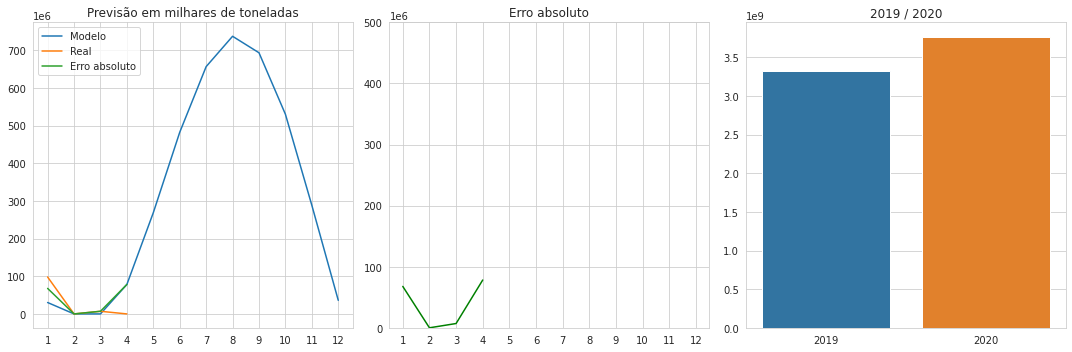

A exportação de Milho esperada para 2020 será de 3,764 milhares de ton, 447 mil ton acima de 2019.


In [18]:
erro = pd.Series(data=(func(range(12*coef+1,12*coef+12), *poptm) - predMilho_test.reset_index(drop=True).fillna(0)).apply(lambda x: sqrt(x**2)))
erro_prop = ((erro/func(range(12*coef+1,12*coef+12), *poptm))*100)
erro_prop.index = erro_prop.index+1
plt.figure(figsize=(15,5))
ax1 = plt.subplot(131)



plt.plot(range(12*coef+1,12*coef+13), func(range(12*coef+1,12*coef+13), *poptm), label='Modelo')
plt.plot(predMilho_test, label='Real')
plt.plot(range(12*coef+1,12*coef+12),erro,label='Erro absoluto')
RMSE = sqrt(mean_squared_error(predMilho_test, func(predMilho_test.index, *poptm)))
plt.legend()
plt.ticklabel_format(axis='y',scilimits=(6,6))
plt.title('Previsão em milhares de toneladas')
plt.xticks(range(12*coef+1,12*coef+13),range(1,13))
print(f'RMSE: {format(RMSE/1000000,".0f")} mil ton')
print(f'Erro máximo: {format(erro.max()/1000000,".0f")} mil ton')

ax2 = plt.subplot(132)

sns.lineplot(x=erro_prop.index,y=erro,color='g')
plt.ticklabel_format(axis='y',scilimits=(6,6))

plt.xlim(0.5,12.5)
plt.xticks(np.arange(1,13))
plt.ylim(0,500000000)
plt.title('Erro absoluto')



ax3 = plt.subplot(133)
exp_2020 = sum(func(range(12*coef+1,12*coef+12), *poptm))
exp_2019 = sum(sant_grao[(sant_grao['NCM']==Milho)&(sant_grao['Ano']==2019)].groupby('Data').sum()['KG'])

sns.barplot(x=[2019,2020],y=[exp_2019,exp_2020],ax=ax3)
plt.title('2019 / 2020')
plt.tight_layout()
plt.show()

print(f'A exportação de Milho esperada para 2020 será de {exp_2020/1000000:,.0f} milhares de ton, {(exp_2020-exp_2019)/1000000:,.0f} mil ton acima de 2019.')

## Modelo Final <a name="modelofinal"></a>

Abaixo os gráficos finais para o modelo, unindo soja e milho.

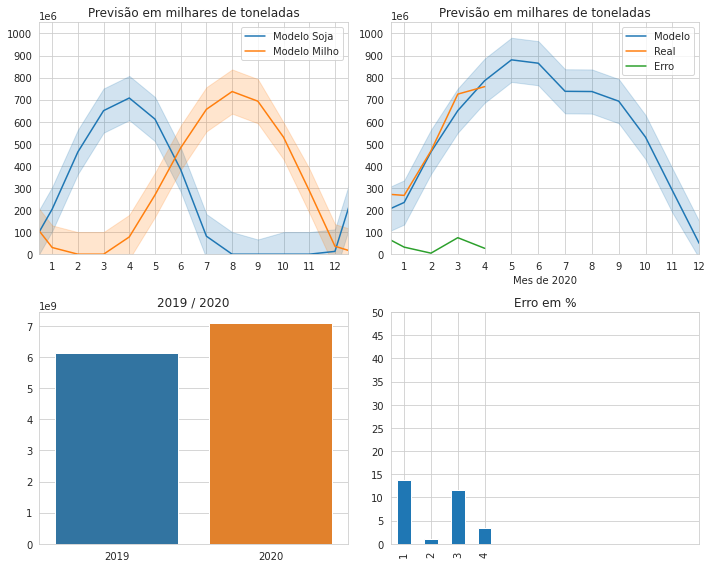

A exportação de graos esperada para 2020 será de 7,094 milhares de ton, 963 mil ton acima de 2019.


In [19]:
plt.figure(figsize=(10,8))

ax1 = plt.subplot(221)
modelo_soja = func(range(12*coef,12*coef+12+2), *popts)
modelo_soja_up = modelo_soja.apply(lambda x: x+100000000)
modelo_soja_down =  modelo_soja.apply(lambda x: x-100000000)
modelo_soja_geral=modelo_soja.append([modelo_soja_down,modelo_soja_up])
sns.lineplot(x=modelo_soja_geral.index,y=modelo_soja_geral.values,label='Modelo Soja')

modelo_milho = func(range(12*coef,12*coef+12+2), *poptm)
modelo_milho_up = modelo_milho.apply(lambda x: x+100000000)
modelo_milho_down =  modelo_milho.apply(lambda x: x-100000000)
modelo_milho_geral=modelo_milho.append([modelo_milho_down,modelo_milho_up])
sns.lineplot(x=modelo_milho_geral.index,y=modelo_milho_geral.values,label='Modelo Milho')

plt.xticks(np.arange(0,13))
plt.xlim(0.5,12.5)
plt.ticklabel_format(axis='y',scilimits=(6,6))
plt.title('Previsão em milhares de toneladas')
plt.legend(loc=0)
plt.yticks(np.arange(0,1050000000,step=100000000))
plt.ylim(0,1050000000)

ax2 = plt.subplot(222)
total_modelo = pd.Series(func(range(12*coef,12*coef+12+1), *popts) + func(range(12*coef,12*coef+12+1), *poptm),index= range(0,13))
total_modelo_up = total_modelo.apply(lambda x: x+100000000)
total_modelo_down = total_modelo.apply(lambda x: x-100000000)
total_modelo_geral=total_modelo.append([total_modelo_down,total_modelo_up])
sns.lineplot(x=total_modelo_geral.index,y=total_modelo_geral.values,label='Modelo')
plt.xticks(np.arange(0,13))
plt.xlim(0.5,12)
plt.ticklabel_format(axis='y',scilimits=(6,6))
plt.yticks(np.arange(0,1050000000,step=100000000))
plt.ylim(0,1050000000)
plt.title('Previsão em milhares de toneladas')

sant_grao['mesNorm'] = (sant_grao['Ano'].apply(lambda x: int(x))-2020)*12 + sant_grao['Mes'].apply(lambda x: int(x))
new_index = range(0,mes_atual)
total_real = sant_grao[(sant_grao['mesNorm']>=0)].groupby(['mesNorm']).sum()['KG'].reindex(new_index, fill_value=0)
plt.plot(total_real,label='Real')

erro = pd.Series(data=total_modelo - total_real.reset_index(drop=True).fillna(0)).apply(lambda x: sqrt(x**2))
plt.plot(erro,label='Erro')
plt.xlabel('Mes de 2020')
plt.legend()

ax3 = plt.subplot(223)
exp_2020 = sum(total_modelo)
exp_2019 = sum(sant_grao[(sant_grao['Ano']==2019)].groupby('Data').sum()['KG'])
sns.barplot(x=[2019,2020],y=[exp_2019,exp_2020],ax=ax3)
plt.title('2019 / 2020')

ax4 = plt.subplot(224)
((erro/total_modelo).fillna(0)*100).reindex(new_index, fill_value=0).plot(kind='bar')
plt.ylim([0,50])
plt.yticks(np.arange(0,55,step=5))
plt.xticks(label=np.arange(1,13))
plt.xlim(0.5,12)
plt.title('Erro em %')


plt.tight_layout()
plt.show()

print(f'A exportação de graos esperada para 2020 será de {exp_2020/1000000:,.0f} milhares de ton, {(exp_2020-exp_2019)/1000000:,.0f} mil ton acima de 2019.')

Os valores de erro continuam resultando abaixo de 100 mil ton, que será considerado o erro máximo aceitavel para o modelo.

O erro relativo ficou abaixo de 15% se demonstrando um modelo robusto por usar apenas os dados anteriores como parâmetro, sem necessitar de dados externos. É possivel dizer que esse modelo consegue predizer a safra 2020.

Por fim, abaixo uma tabela com os valores máximos e minimos esperados para cada mês em 2020.

In [20]:
resultado = pd.DataFrame(data=[total_modelo_up,total_modelo_down,modelo_soja_up,modelo_soja_down,modelo_milho_up,modelo_milho_down], \
                         index=['Máximo Total','Minimo Total','Máximo Soja','Minimo Soja','Máximo Milho','Minimo Milho'])
resultado = resultado.transpose()
for i in resultado.columns:
  resultado[i] = resultado[i].apply(lambda x: format(x/1000000,'05.2f') if x > 0 else format(000,"06.2f"))
resultado = resultado[1:13]
resultado.index.name = 'Mes'
print('Valores esperados em milhares de tonelada a cada mês.')
resultado

Valores esperados em milhares de tonelada a cada mês.


,Máximo Total,Minimo Total,Máximo Soja,Minimo Soja,Máximo Milho,Minimo Milho
Mes,,,,,,
1,334.39,134.39,304.11,104.11,130.28,000.00
2,563.31,363.31,563.31,363.31,100.00,000.00
3,750.35,550.35,750.35,550.35,100.00,000.00
4,885.74,685.74,807.51,607.51,178.23,000.00
5,980.38,780.38,711.76,511.76,368.62,168.62
6,965.18,765.18,483.17,283.17,582.00,382.00
7,837.82,637.82,181.49,000.00,756.33,556.33
8,836.85,636.85,100.00,000.00,836.85,636.85
9,793.12,593.12,100.00,000.00,793.12,593.12


## Considerações finais <a name="conclusao"></a>

O modelo até então se mostra capaz de predizer as toneladas de grãos que serão exportados em 2020 no porto de Santarém com 15% de erro, ou até 100 mil ton em valores absolutos.

O codigo pode ser facilmente adaptado para outros portos alterando a variavel Porto no inicio do notebook. Talvez o modelo para outros portos precise de ajustes como o realizado no milho, dependerá da análise.

Vale observar que os valores aqui expostos são de grãos efetivamente exportados, não considerando a demanda para exportação que foi limitada por motivos tecnicos e operacionais do porto, entretando caso os valores sejam substituidos, é possivel fazer a predição das demandas, infelizmente esses dados são privados e não é possivel realizar essa análise.